**Name:** Fatima Azfar<br>

### Note:
The accuracy of this model is not good, I tried to implement the exact architecture as proposed in the paper but because the dimensions of my dataset are 64x64 instead of 224x224 the final results are not very promising. 
### Dataset:
Tiny ImageNet was downscaled to 10 classes and 100 images per class for the demonstration of this architecture.

# Imports

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load Tiny ImageNet Data

In [8]:
def load_dataset(dataset_dir, split='train', images_per_class=100, selected_classes=None):
    assert split in ['train', 'val'], "split must be 'train' or 'val'"
    split_dir = os.path.join(dataset_dir, split)

    images = []
    labels = []

    if split == 'train':
        for label_dir in os.listdir(split_dir):
            class_id = label_dir  # 'nXXXXXX'
            if selected_classes is not None and class_id not in selected_classes:
                continue  # Skip classes not in the selected subset
            class_dir = os.path.join(split_dir, label_dir, 'images')
            class_images = os.listdir(class_dir)[:images_per_class]  # Selecting only 100 images per class
            for image_file in class_images:
                image_path = os.path.join(class_dir, image_file)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
                image = tf.keras.preprocessing.image.img_to_array(image)
                images.append(image)
                labels.append(class_id)
    elif split == 'val':
        val_annotations_path = os.path.join(split_dir, 'val_annotations.txt')
        with open(val_annotations_path, 'r') as f:
            val_annotations = f.readlines()
        
        class_counts = {}
        for line in val_annotations:
            items = line.strip().split('\t')
            image_file, class_id = items[0], items[1]
            if selected_classes is not None and class_id not in selected_classes:
                continue
            if class_id not in class_counts:
                class_counts[class_id] = 0
            if class_counts[class_id] < images_per_class:
                class_counts[class_id] += 1
                image_path = os.path.join(split_dir, 'images', image_file)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
                image = tf.keras.preprocessing.image.img_to_array(image)
                images.append(image)
                labels.append(class_id)

    images = np.array(images)
    if labels:
        unique_labels = sorted(list(set(labels)))
        label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
        labels = np.array([label_to_id[label] for label in labels])
    else:
        labels = None

    return images, labels

dataset_dir = r'D:\Users\Nadeem\Desktop\BSDS\Semester 8\CV\AlexNet\tiny-imagenet-200'
selected_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 
                    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']

train_images, train_labels = load_dataset(dataset_dir, 'train', images_per_class=100, selected_classes=selected_classes)
val_images, val_labels = load_dataset(dataset_dir, 'val', images_per_class=100, selected_classes=selected_classes)

train_images, val_images = train_images / 255.0, val_images / 255.0

# VGG16

In [17]:
BATCH_SIZE = 256
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
INIT_LR = 1e-2
NUM_EPOCHS = 74
NUM_CLASSES = 10

def VGG16(input_shape=(64, 64, 3), num_classes=10):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # FC layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(WEIGHT_DECAY)))
    
    return model
    
model = VGG16(input_shape=(64, 64, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                

# Model Training

In [ ]:
model = VGG16(input_shape=(64, 64, 3), num_classes=NUM_CLASSES)

optimizer = SGD(learning_rate=INIT_LR, momentum=MOMENTUM)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

def lr_scheduler(epoch, lr):
    if epoch in [int(NUM_EPOCHS * 0.5), int(NUM_EPOCHS * 0.7), int(NUM_EPOCHS * 0.9)]:
        lr *= 0.1
    return lr

callbacks = [
    LearningRateScheduler(lr_scheduler),
    ModelCheckpoint('vgg16_best_model.h5', save_best_only=True, monitor='val_accuracy')
]

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=NUM_CLASSES)
val_labels_one_hot = to_categorical(val_labels, num_classes=NUM_CLASSES)

history = model.fit(
    train_datagen.flow(train_images, train_labels_one_hot, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_images) // BATCH_SIZE,
    validation_data=val_datagen.flow(val_images, val_labels_one_hot, batch_size=BATCH_SIZE),
    validation_steps=len(val_images) // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=callbacks
)

# Model Evaluation

In [14]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_images, val_labels_one_hot)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

16/16 [==============================] - 9s 441ms/step - loss: 7.5369 - accuracy: 0.1000
Validation loss: 7.53688907623291, Validation accuracy: 0.10000000149011612


# Model Training Visualizations

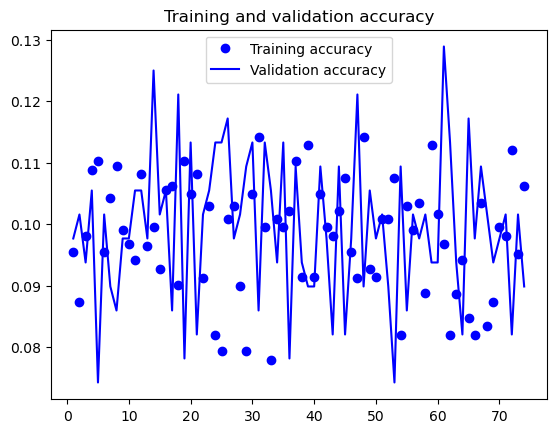

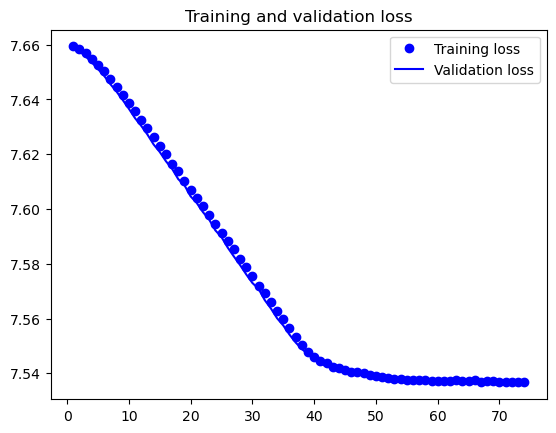

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Top K Validation Error and Accuracy

In [16]:
# predictions on the validation set
val_predictions = model.predict(val_images)

# top-1 error rate
val_top1_errors = np.argmax(val_predictions, axis=1) != val_labels
val_top1_error_rate = np.mean(val_top1_errors)
val_top1_accuracy = 1 - val_top1_error_rate
print("Validation Top-1 Error Rate:", val_top1_error_rate)
print("Validation Top-1 Accuracy:", val_top1_accuracy)

# top-5 error rate
val_top5_errors = np.ones_like(val_top1_errors)
for i in range(len(val_predictions)):
    val_top5_indices = np.argsort(val_predictions[i])[-5:]
    if val_labels[i] in val_top5_indices:
        val_top5_errors[i] = 0
val_top5_error_rate = np.mean(val_top5_errors)
val_top5_accuracy = 1 - val_top5_error_rate
print("Validation Top-5 Error Rate:", val_top5_error_rate)
print("Validation Top-5 Accuracy:", val_top5_accuracy)

16/16 [==============================] - 17s 428ms/step
Validation Top-1 Error Rate: 0.9
Validation Top-1 Accuracy: 0.09999999999999998
Validation Top-5 Error Rate: 0.5
Validation Top-5 Accuracy: 0.5
